In [1]:
import numpy as np
import xarray as xr

# Create 'toy' criteria selection data
np.random.normal(loc=3.5, scale=1.5, size=50)
#crit['delta_annual_tavg']
np.random.seed(0)
test = xr.DataArray(np.random.normal(loc=3, scale=1.5, size=100), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=5.34, scale=2, size=100), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')
ds_crit = xr.Dataset()
ds_crit['delta_annual_tavg'] = test
test = xr.DataArray(np.random.normal(loc=5, scale=5, size=100), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=10, scale=8, size=100), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')
ds_crit['delta_annual_prtot'] = test

test = xr.DataArray(np.random.normal(loc=0, scale=3, size=100), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=2, scale=4, size=100), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')
ds_crit['delta_JJA_prtot'] = test

Ensemble -  Reduction Techniques
=================================

`xclim.ensembles` provides means of reducing the number of candidates in a sample to get a reasonable and representative spread of outcomes using a reduced number of candidates. By reducing the number of realizations in a strategic manner, we can significantly reduce the number of relizations that are considered, while maintaining statistical representation of original dataset. This is particularly useful when computation power or time is a factor.

**Selection Criteria** 
ADD TEXT HERE - pretend delta values IN THIS CASE WE HAVE A TOTAL OF 6 CRITERIA (3 delta variables with 2 horizons). We want to reduce the number of runs while still covering uncertainty in the 6 criteria

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xclim import ensembles

# Using an xarray dataset of our criteria
ds_crit: xr.Dataset
ds_crit

<xarray.Dataset>
Dimensions:             (horizon: 2, realization: 100)
Coordinates:
  * horizon             (horizon) object '2041-2070' '2071-2100'
Dimensions without coordinates: realization
Data variables:
    delta_annual_tavg   (horizon, realization) float64 5.646 3.6 ... 9.666 8.013
    delta_annual_prtot  (horizon, realization) float64 3.154 3.803 ... 16.82
    delta_JJA_prtot     (horizon, realization) float64 -1.796 -3.348 ... 1.286

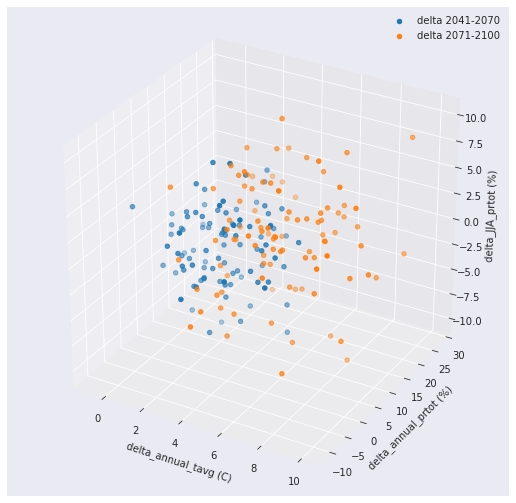

In [3]:
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (13, 5)
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')

for h in ds_crit.horizon:
    ax.scatter(ds_crit.sel(horizon=h).delta_annual_tavg, ds_crit.sel(horizon=h).delta_annual_prtot,
            ds_crit.sel(horizon=h).delta_JJA_prtot,label=f"delta {h.values}")

ax.set_xlabel('delta_annual_tavg (C)')
ax.set_ylabel('delta_annual_prtot (%)')
ax.set_zlabel('delta_JJA_prtot (%)')
plt.legend()

Ensemble reduction techniques require a 2D array with dimensions of `criteria` and `realization`

In [4]:
# Create 2d xr.DataArray containincg criteria values
crit=None
for h in ds_crit.horizon:
    for v in ds_crit.data_vars:
        if crit is None:
            crit = ds_crit[v].sel(horizon=h)
        else:
            crit = xr.concat((crit, ds_crit[v].sel(horizon=h)), dim='criteria')
crit.name= 'criteria'
crit.shape

(6, 100)

#### **K-Means reduce ensemble**

The `kmeans_reduce_ensemble` works by grouping realizations into sub-groups based on the provided critera and retaining a representative `realization` per sub-group
* Example using `method = n_clusters`  
* The function  returns the `ids` of the selected realizations
* In this example we reduce the original 100 realizations to n=25

In [5]:
ids, cluster, fig_data = ensembles.kmeans_reduce_ensemble(data=crit, method={'n_clusters':25}, random_state=42, make_graph=True)
ds_crit.isel(realization = ids)

<xarray.Dataset>
Dimensions:             (horizon: 2, realization: 25)
Coordinates:
  * horizon             (horizon) object '2041-2070' '2071-2100'
Dimensions without coordinates: realization
Data variables:
    delta_annual_tavg   (horizon, realization) float64 3.6 2.773 ... 5.874 6.884
    delta_annual_prtot  (horizon, realization) float64 3.803 1.31 ... 16.86
    delta_JJA_prtot     (horizon, realization) float64 -3.348 0.1768 ... 0.1199

We can now compare the distribution of the selection versus the original ensemble

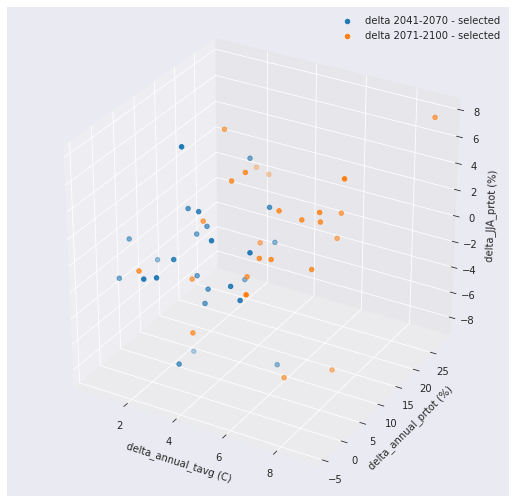

In [6]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')

for h in ds_crit.horizon:
    ax.scatter(ds_crit.sel(horizon=h,realization=ids).delta_annual_tavg, ds_crit.sel(horizon=h, realization=ids).delta_annual_prtot ,
            ds_crit.sel(horizon=h,realization=ids).delta_JJA_prtot,label=f"delta {h.values} - selected")

ax.set_xlabel('delta_annual_tavg (C)')
ax.set_ylabel('delta_annual_prtot (%)')
ax.set_zlabel('delta_JJA_prtot (%)')
plt.legend()

The function optionally produces a data dictionary for figure production of the associated R² profile. 
The function`ensembles.plot_rsqprofile` provides plotting for evaluating the proportion of total variance in climate realizations that is covered by the selection.  In this case ~78% of the total variance in original ensemble is covered by the selection

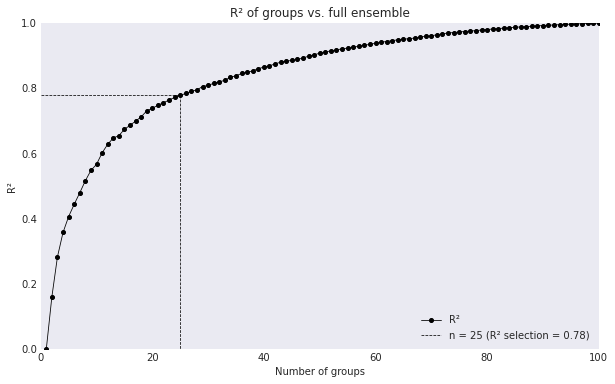

In [7]:
ensembles.plot_rsqprofile(fig_data)

Alternatively we can use `method = {'rsq_cutoff':Float}` or `method = {'rsq_optimize':None}`
* For example with `rsq_cutoff` we instead find the number of realizations needed to cover the provided $R^{2}$ value

<xarray.Dataset>
Dimensions:             (horizon: 2, realization: 38)
Coordinates:
  * horizon             (horizon) object '2041-2070' '2071-2100'
Dimensions without coordinates: realization
Data variables:
    delta_annual_tavg   (horizon, realization) float64 4.468 6.361 ... 8.013
    delta_annual_prtot  (horizon, realization) float64 10.5 8.276 ... 16.82
    delta_JJA_prtot     (horizon, realization) float64 2.3 1.069 ... 4.173 1.286

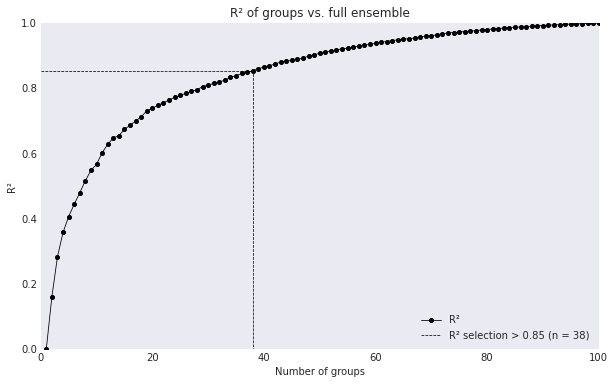

In [8]:
ids1, cluster1, fig_data1 = ensembles.kmeans_reduce_ensemble(data=crit, method={'rsq_cutoff':0.85}, random_state=42, make_graph=True)
ensembles.plot_rsqprofile(fig_data1)
ds_crit.isel(realization=ids1)

#### **KKZ reduce ensemble**
TODO BETTER DESCRIPTIONS HERE...

A similar ensemble reduction algorithm `ensembles.kkz_reduce_ensemble` is also available
* Describe difference - big advantage .. NESTED results.

In [9]:
ids = ensembles.kkz_reduce_ensemble(crit, num_select=10)
ds_crit.isel(realization=ids)

<xarray.Dataset>
Dimensions:             (horizon: 2, realization: 10)
Coordinates:
  * horizon             (horizon) object '2041-2070' '2071-2100'
Dimensions without coordinates: realization
Data variables:
    delta_annual_tavg   (horizon, realization) float64 2.958 2.719 ... 0.8932
    delta_annual_prtot  (horizon, realization) float64 8.458 6.161 ... 1.82
    delta_JJA_prtot     (horizon, realization) float64 1.017 -8.219 ... 5.14

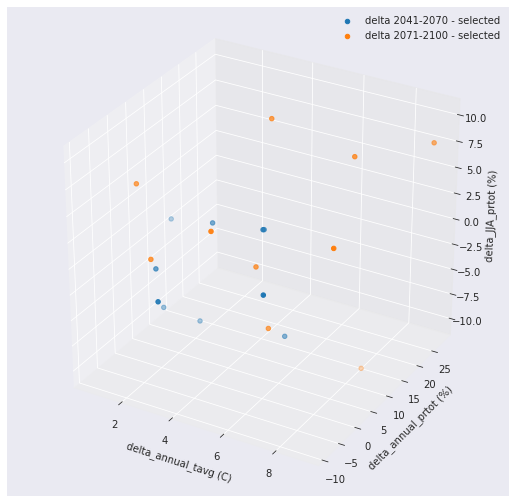

In [10]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')

for h in ds_crit.horizon:

    ax.scatter(ds_crit.sel(horizon=h,realization=ids).delta_annual_tavg, ds_crit.sel(horizon=h, realization=ids).delta_annual_prtot ,
            ds_crit.sel(horizon=h,realization=ids).delta_JJA_prtot,label=f"delta {h.values} - selected")

ax.set_xlabel('delta_annual_tavg (C)')
ax.set_ylabel('delta_annual_prtot (%)')
ax.set_zlabel('delta_JJA_prtot (%)')
plt.legend()

In [11]:
## NESTED results using KKZ
for n in np.arange(5, 13):
    ids = ensembles.kkz_reduce_ensemble(crit, num_select=n)
    print(ids)
    

[54, 27, 71, 85, 60]
[54, 27, 71, 85, 60, 24]
[54, 27, 71, 85, 60, 24, 11]
[54, 27, 71, 85, 60, 24, 11, 68]
[54, 27, 71, 85, 60, 24, 11, 68, 89]
[54, 27, 71, 85, 60, 24, 11, 68, 89, 83]
[54, 27, 71, 85, 60, 24, 11, 68, 89, 83, 20]
[54, 27, 71, 85, 60, 24, 11, 68, 89, 83, 20, 1]


In [12]:
## UNNESTED results using k-means
for n in np.arange(5, 13):
    ids, cluster, fig_data = ensembles.kmeans_reduce_ensemble(crit, method={'n_clusters':n}, random_state=42, make_graph=True)
    print(ids)

[7, 26, 42, 73, 96]
[7, 16, 25, 26, 73, 96]
[7, 16, 26, 40, 42, 64, 96]
[16, 21, 26, 28, 40, 42, 49, 96]
[7, 15, 16, 25, 28, 49, 61, 73, 95]
[7, 15, 16, 40, 42, 47, 49, 61, 67, 95]
[7, 16, 38, 40, 42, 47, 49, 61, 67, 86, 92]
[5, 7, 13, 16, 25, 26, 40, 49, 57, 61, 73, 95]
